/home/yhy/my_project/UnCLE/.venv/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip

/home/yhy/my_project/UnCLE/.venv/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip

/home/yhy/my_project/UnCLE/.venv/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip



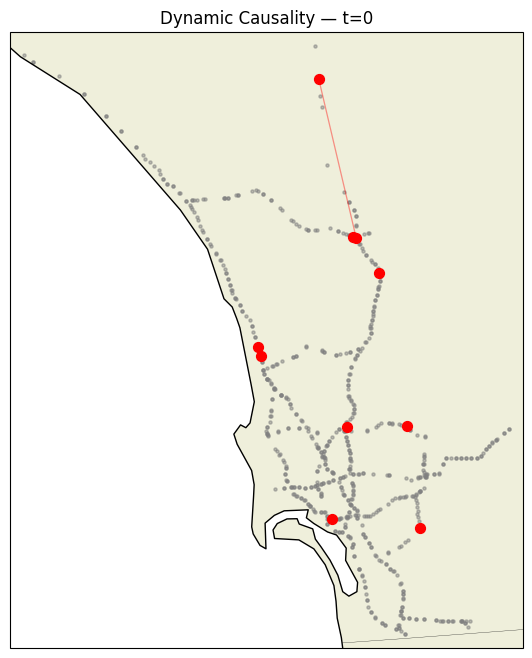

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature


MATRIX_PATH = "../results/SD/20251125_165145/est_dynamic.npy"
META_PATH = "../data/real/data/SD/sd_meta.csv"
# ================================
# 1. 加载数据
# ================================
C = np.load(MATRIX_PATH)  # (716,716,200)
meta = pd.read_csv(META_PATH)

lat = meta["Lat"].values
lng = meta["Lng"].values

T = C.shape[2]
N = C.shape[0]

# ================================
# 2. 计算节点重要度 (out-strength)
# ================================
importance = np.sum(np.abs(C), axis=(1,2))  # (716,)
top_k = 10
top_idx = np.argsort(importance)[-top_k:]

# ================================
# 3. 取 716 × top10 的子矩阵
# ================================
C_reduced = C[:, top_idx, :]   # (716,10,200)

# 归一化
C_norm = C_reduced / np.max(np.abs(C_reduced))

# 阈值过滤
threshold = 0.2
mask = np.abs(C_norm) > threshold

# ================================
# 4. 画布设置（cartopy 地图）
# ================================
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lng.min()-0.02, lng.max()+0.02, lat.min()-0.02, lat.max()+0.02])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)

# 绘制固定节点（top10 + all716）
ax.scatter(lng, lat, s=5, c='gray', alpha=0.5, transform=ccrs.PlateCarree())
ax.scatter(lng[top_idx], lat[top_idx], s=50, c='red', transform=ccrs.PlateCarree())

lines = []
for _ in range(N * top_k):
    line, = ax.plot([], [], linewidth=0.4, alpha=0.6, transform=ccrs.PlateCarree())
    lines.append(line)

# ================================
# 5. 动态函数
# ================================
def animate(t):
    k = 0
    for i in range(N):
        for j in range(top_k):
            if mask[i, j, t]:
                x = [lng[i], lng[top_idx[j]]]
                y = [lat[i], lat[top_idx[j]]]
                strength = abs(C_norm[i, j, t])
                color = 'red' if C_norm[i, j, t] > 0 else 'blue'
                lines[k].set_data(x, y)
                lines[k].set_color(color)
                lines[k].set_linewidth(0.5 + 2*strength)
                lines[k].set_alpha(0.3 + 0.5*strength)
            else:
                lines[k].set_data([], [])
            k += 1
    ax.set_title(f"Dynamic Causality — t={t}")
    return lines

anim = FuncAnimation(fig, animate, frames=T, interval=100)
anim.save("dynamic_causality.mp4", dpi=150)
